# 資料分析專案-作業流程

### 一、資料蒐集、定義目標:
- [x] 資料來源
- [x] 特徵說明

### 二、資料前處理: 
- [x] EDA資料分布
- [x] 資料型態調整
- [x] 離群值處理
- [x] 特徵縮放/標準化
- [x] 分析變數關聯性

In [29]:
# 引用所需套件
# pip install imblearn

import numpy as np
import pandas as pd
import copy
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

#處理資料偏態
from scipy.stats import skew
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from scipy.stats import boxcox
from scipy.special import inv_boxcox

#訓練模型
from sklearn import metrics
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV


#特徵工程
from sklearn.preprocessing import MinMaxScaler, StandardScaler,RobustScaler, OneHotEncoder,PowerTransformer

#演算法
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

#處理資料不平衡
from imblearn.over_sampling import SMOTE, ADASYN

warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 5000)
plt.style.use('seaborn')
%matplotlib inline

In [ ]:
# 讀取資料

train_data = pd.read_csv('./train_data.csv')
test_data = pd.read_csv('./test_features.csv')
data = pd.concat([train_data, test_data], axis = 0)

print(f'train shape: {train_data.shape}')
print(f'test shape: {test_data.shape}')
print(f'total shape: {data.shape}')

data.reset_index(inplace=True, drop=True)
data.head()

In [ ]:
# 檢查 DataFrame 空缺值的狀態

def na_check(df_data, axis):
    data_na = (df_data.isnull().sum(axis = axis) / df_data.shape[axis]) * 100
    data_na = data_na.drop(data_na[data_na == 0].index).sort_values(ascending=False)
    missing_data = pd.DataFrame({'Missing Ratio' :data_na})
    return missing_data

#查看一下每個變數(欄位)的遺失值狀況
print(na_check(data, 0))

In [ ]:
#看一下每筆資料的遺失值狀況
print(na_check(data, 1))

In [160]:
# 填補遺失值

df_payment = data[payment_columns]
df_payment = df_payment.fillna(0)

In [ ]:
# 丟棄部分資料
df = df.drop(missing_indexs, axis = 0) 

print(f'shape: {df.shape}') 
df.reset_index(inplace=True, drop=True)
df

In [171]:
#修正部分錯誤資料

# BELFER, ROBERT 資料有誤
df_stock.at[50, 'exercised_stock_options'] =  0
df_stock.at[50, 'restricted_stock'] =  44093
df_stock.at[50, 'restricted_stock_deferred'] =  -44093
df_stock.at[50, 'total_stock_value'] =  0
# BHATNAGAR SANJAY 資料有誤
df_stock.at[139, 'exercised_stock_options'] =  15456290.0
df_stock.at[139, 'restricted_stock'] =  2604490.0
df_stock.at[139, 'restricted_stock_deferred'] =  -2604490.0
df_stock.at[139, 'total_stock_value'] =  15456290.0

In [ ]:
#新增特徵組合

df_stock['exercised_total_ratio'] = df_stock['exercised_stock_options'] / df_stock['total_stock_value']
df_stock['restricted_total_ratio'] = df_stock['restricted_stock'] / df_stock['total_stock_value']
df_stock['exercised_restricted_ratio'] = df_stock['exercised_stock_options'] / df_stock['restricted_stock']
df_stock['restricted_stock_deferred'] = abs(df_stock['restricted_stock_deferred'])

#計算後修正
df_stock.replace(np.inf, 0, inplace = True)
df_stock = df_stock.fillna(0)

pd.concat([data.name, df_stock], axis = 1)

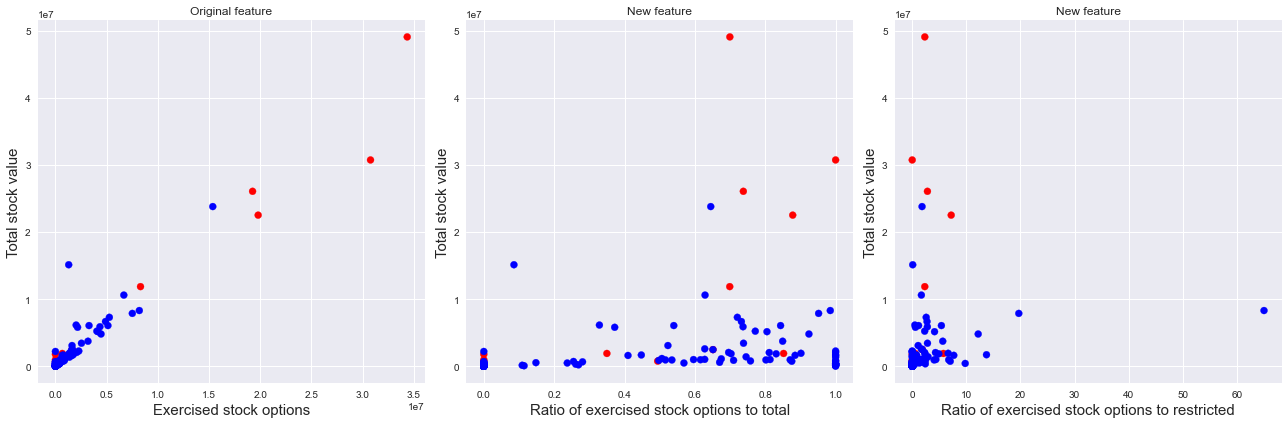

In [173]:
# 繪圖觀察變數之間的分布

train_num = train_data.shape[0]
color = ['r' if i == True else 'b' for i in train_data.poi]  #繪製資料點散佈圖，poi資料點為紅色，反之為藍色

figure, (axes1, axes2, axes3) = plt.subplots(ncols = 3, nrows = 1, figsize = (18, 6))
axes1.scatter(df_stock['exercised_stock_options'][:train_num], df_stock['total_stock_value'][:train_num], c = color)
axes1.set_xlabel('Exercised stock options', fontsize = 15)
axes1.set_ylabel('Total stock value', fontsize = 15)
axes1.set_title('Original feature')


axes2.scatter(df_stock['exercised_total_ratio'][:train_num], df_stock['total_stock_value'][:train_num], c = color)
axes2.set_xlabel('Ratio of exercised stock options to total', fontsize = 15)
axes2.set_ylabel('Total stock value', fontsize = 15)
axes2.set_title('New feature')

axes3.scatter(df_stock['exercised_restricted_ratio'][:train_num], df_stock['total_stock_value'][:train_num], c = color)
axes3.set_xlabel('Ratio of exercised stock options to restricted', fontsize = 15)
axes3.set_ylabel('Total stock value', fontsize = 15)
axes3.set_title('New feature')

figure.tight_layout()
plt.show()

In [180]:
# 將訓練、測試資料分開，避免誤刪
# 前108筆為訓練資料，後33筆為測試資料
df_train = df[:108]
df_test = df[108:]

In [181]:
# 找離群值
outliers = dict()

for feature in df_train.columns:
    if df_train[feature].dtypes == 'float':
        # 統計數續還是用全部的資料
        q25 = df[feature].quantile(0.25)
        q50 = df[feature].quantile(0.5)
        q75 = df[feature].quantile(0.75)
        IQR = q75 - q25
        
        for i in range(108):
            if df_train[feature][i] > q50 + 1.5 * IQR or df_train[feature][i] < q50 - 1.5 * IQR: #1.5倍IQR原則
                if df_train['name'][i] not in outliers:
                    outliers[df_train['name'][i]] = 1
                else:
                    outliers[df_train['name'][i]] += 1

In [ ]:
df_outliers = pd.DataFrame(outliers.keys(), outliers.values()).reset_index().sort_values(by = 'index', ascending = False)
df_outliers.columns = ['number', 'name']  #重新命名dataframe的欄位
df_outliers

In [ ]:
#把目標變數加入，查看離群值的分布

df_outliers['poi'] = [1 if df_outliers['name'].values[i] in df_train['name'].values[:13] else 0 for i in range(len(df_outliers))]
df_outliers

In [184]:
#重新把資料拼起來
df = pd.concat([df_train, df_test], axis = 0)
df.reset_index(inplace = True, drop = True)
print(df.shape) #訓練資料108筆，測試資料33筆

(141, 31)


### 三、特徵工程: 
- [x] 去除偏態
- [x] 特徵編碼
- [x] 特徵組合
- [x] 特徵選擇
- [x] 特徵評估

In [ ]:
#處理資料偏態問題，針對數值欄位，計算資料偏態係數
numeric_features = df.dtypes[df.dtypes != "object"].index
skew_of_features = df[numeric_features].apply(lambda x: skew(x, nan_policy = 'omit')).sort_values(ascending=False)
print(skew_of_features)

In [ ]:
# 偏態係數超過0.9的部分進行後續調整

high_skewness = skew_of_features[abs(skew_of_features.values) > 0.9]
skewed_features = high_skewness.index
print(skewed_features)

In [187]:
#透過套件函數修正偏態
for feature in skewed_features:
    df[feature] = boxcox1p(df[feature], boxcox_normmax(df[feature] + 1))

In [ ]:
# 看一下修正過偏態後的資料分布

train_num = 108
color = ['r' if i == True else 'b' for i in df[:train_num]['poi']] #繪製資料點散佈圖，poi資料點為紅色，反之為藍色

figure, (axes1, axes2, axes3, axes4) = plt.subplots(ncols = 4, nrows = 1, figsize = (24, 6))
axes1.scatter(df['from_poi_to_this_person'][:train_num], df['from_this_person_to_poi'][:train_num], c = color)
axes1.set_xlabel('Number of emails from poi to this person', fontsize = 15)
axes1.set_ylabel('Number of emails from this person to poi', fontsize = 15)
axes1.set_title('Original feature')


axes2.scatter(df['from_poi_ratio'][:train_num], df['to_poi_ratio'][:train_num], c = color)
axes2.set_xlabel('Ratio of emails from poi to this person', fontsize = 15)
axes2.set_ylabel('Ratio of emails from this person to poi', fontsize = 15)
axes2.set_title('New feature')

axes3.scatter(df['to_messages'][:train_num], df['shared_receipt_with_poi'][:train_num], c = color)
axes3.set_xlabel('Number of emails sent to this person', fontsize = 15)
axes3.set_ylabel('Number of receipts sent to this person with poi', fontsize = 15)
axes3.set_title('Original feature')

axes4.scatter(df['to_messages'][:train_num], df['poi_receipt_ratio'][:train_num], c = color)
axes4.set_xlabel('Number of emails sent to this person', fontsize = 15)
axes4.set_ylabel('Ratio of receipts sent to this person with poi', fontsize = 15)
axes4.set_title('New feature')

figure.tight_layout()
plt.show()

In [ ]:
# 開始訓練模型前的最後一段特徵工程:資料標準化

target = df['poi'][:train_num].astype('int') #先把poi這個二元變數轉為數值變數，獨立儲存
df.drop(['name', 'poi'], axis = 1, inplace = True)  

mmencoder = MinMaxScaler() #數值變數都使用最大最小值標準化處理
df[:] = mmencoder.fit_transform(df)

#切分資料集
df_train = df[:train_num]
df_test = df[train_num:]
print(f'train shape: {df_train.shape}')
print(f'test shape: {df_test.shape}')

In [ ]:
# 平衡資料標籤

# SMOTE
sm = SMOTE(random_state = 42)
train_data_res,train_Y_res = sm.fit_resample(df_train, target)
train_data_res = pd.DataFrame(train_data_res, columns = df.columns)

x = train_data_res
y = train_Y_res
print(f'x shape: {x.shape}')

model_selection(x, y, 10)

### 四、設定評估準則: 
- [x] 決定評估指標

### 五、建立模型: 
- [x] 定義模型
- [x] 評估模型
- [x] 最佳化模型

In [194]:
#設定隨機種子
randomState = 42

def model_selection(x, y, cv):  #訓練資料、目標變數、交叉驗證次數
    
    # NAIBE BAYES
    nb_model = GaussianNB()
    nb_score = cross_val_score(nb_model, x, y, cv = cv, scoring = 'roc_auc')
    print(f'Naive Bayes: {nb_score.mean()} \u00B1 {nb_score.std()}')

    #KNN
    knn_model = KNeighborsClassifier()
    knn_score = cross_val_score(knn_model, x, y, cv = cv, scoring = 'roc_auc')
    print(f'KNN: {knn_score.mean()} \u00B1 {knn_score.std()}')

    

    #LOGISTIC REGRESSION
    lr_model = LogisticRegression()
    lr_score = cross_val_score(lr_model, x, y, cv = cv, scoring = 'roc_auc')
    print(f'Logistic Regression: {lr_score.mean()} \u00B1 {lr_score.std()}')

    #SVM
    svc_model = SVC()
    svc_score = cross_val_score(svc_model, x, y, cv = cv, scoring = 'roc_auc')
    print(f'SVM: {svc_score.mean()} \u00B1 {svc_score.std()}')

    #DECISON TREE
    dtree_model = DecisionTreeClassifier()
    dtree_score = cross_val_score(dtree_model, x, y, cv = cv, scoring = 'roc_auc')
    print(f'Decision Tree: {dtree_score.mean()} \u00B1 {dtree_score.std()}')
    
    #RANDOM FOREST
    rfc_model = RandomForestClassifier(n_estimators = 100,random_state = randomState)
    rfc_score = cross_val_score(rfc_model, x, y, cv = cv, scoring = 'roc_auc')
    print(f'Random Forest: {rfc_score.mean()} \u00B1 {rfc_score.std()}')
    
    #GRADIENT BOOSTING
    gdbt_model = GradientBoostingClassifier(random_state = randomState)
    gdbt_score = cross_val_score(gdbt_model, x, y, cv = cv, scoring = 'roc_auc')
    print(f'Gradient Boosting: {gdbt_score.mean()} \u00B1 {gdbt_score.std()}')

    #XGBOOST
    xgb = XGBClassifier(random_state = randomState)
    xgb_score = cross_val_score(xgb, x, y, cv = cv, scoring = 'roc_auc')
    print(f'XGBoost: {xgb_score.mean()} \u00B1 {xgb_score.std()}')

In [195]:
x = df_train
y = target
print(f'x shape: {x.shape}')

# model training
model_selection(x, y, 10)

x shape: (108, 29)
Naive Bayes: 0.8322222222222223 ± 0.18226625484252698
KNN: 0.72 ± 0.1895283294241813
Logistic Regression: 0.8644444444444443 ± 0.17531629265169796
SVM: 0.8444444444444444 ± 0.26251396200376387
Decision Tree: 0.643888888888889 ± 0.21054676029710107
Random Forest: 0.835 ± 0.2348107985402527
Gradient Boosting: 0.7861111111111111 ± 0.17400954280629072
XGBoost: 0.861111111111111 ± 0.14446581038560774


In [196]:
# 特徵重要性分析

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state = randomState)

gdbt_model = RandomForestClassifier(n_estimators = 100, random_state = 42)
gdbt_model.fit(x_train, y_train)
FI = pd.DataFrame({'feature':x.columns, 'importance':gdbt_model.feature_importances_}).sort_values(by = 'importance', ascending = False)
FI

,feature,importance
12,exercised_stock_options,0.104873
15,total_stock_value,0.091832
5,other,0.084614
28,total_value,0.071039
8,total_payments,0.060171
13,restricted_stock,0.054658
11,bonus_salary_ratio,0.052823
0,salary,0.050860
25,to_poi_ratio,0.050628
6,expenses,0.049715


shape of x: (108, 1) RF: 0.6544444444444445 ± 0.28865161195881056
shape of x: (108, 2) RF: 0.7166666666666667 ± 0.2908586691712983
shape of x: (108, 3) RF: 0.82 ± 0.18931650942466888
shape of x: (108, 4) RF: 0.8383333333333333 ± 0.13399027972852506
shape of x: (108, 5) RF: 0.8161111111111111 ± 0.16730341329083948
shape of x: (108, 6) RF: 0.7883333333333333 ± 0.2282576246478451
shape of x: (108, 7) RF: 0.7411111111111112 ± 0.27618655352076615
shape of x: (108, 8) RF: 0.7383333333333333 ± 0.24692491486329787
shape of x: (108, 9) RF: 0.793888888888889 ± 0.17875512597329452
shape of x: (108, 10) RF: 0.7538888888888889 ± 0.1923706876878114
shape of x: (108, 11) RF: 0.7911111111111112 ± 0.18052050941925588
shape of x: (108, 12) RF: 0.8016666666666665 ± 0.19659210764962934
shape of x: (108, 13) RF: 0.8311111111111111 ± 0.16663332999933317
shape of x: (108, 14) RF: 0.8472222222222221 ± 0.16358729311635364
shape of x: (108, 15) RF: 0.8277777777777778 ± 0.1998301748120941
shape of x: (108, 16) R

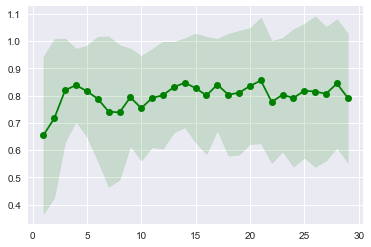

In [197]:
# 大致了解每個變數對模型的解釋度重要性後，使用逐步加入法，觀察變數逐一加入模型對於提升解釋度的增益為何

#生成初始化陣列，儲存模型預測分數的平均值和標準差
_mean = np.empty(df.shape[1])
_std = np.empty(df.shape[1])

clf = RandomForestClassifier(random_state = randomState)

for i in range(df.shape[1]):  #逐一加入變數，共計29個變數
    print(f'shape of x: {x[FI.feature[:i+1]].shape}', end = ' ')
    score = cross_val_score(clf, x[FI.feature[:i+1]], y, cv = 10, scoring = 'roc_auc')
    _mean[i] = score.mean()
    _std[i] = score.std()
    print(f'RF: {score.mean()} \u00B1 {score.std()}')
    
plt.plot(range(1, df.shape[1] + 1), _mean, color = 'g', marker = 'o')
plt.fill_between(range(1, df.shape[1] + 1), _mean + _std, _mean - _std, alpha = 0.15, color = 'green')
plt.show()

In [198]:
# 特徵篩選後的模型
x = df_train[FI.feature[:25]]
y = target
print(f'shape of x: {x.shape}')

model_selection(x, y, 10)

shape of x: (108, 25)
Naive Bayes: 0.8533333333333333 ± 0.17074997966487598
KNN: 0.6772222222222222 ± 0.21371854688807573
Logistic Regression: 0.8644444444444443 ± 0.17531629265169796
SVM: 0.861111111111111 ± 0.26068523188599846
Decision Tree: 0.6144444444444443 ± 0.18421002506197467
Random Forest: 0.8177777777777779 ± 0.24626594076373395
Gradient Boosting: 0.7961111111111111 ± 0.15315710484803535
XGBoost: 0.8100000000000002 ± 0.20174852945140012


### 六、調整參數: 
- [x] 超參數調整
- [x] 集成學習

In [199]:
#RANDOM FOREST
rfc_model = RandomForestClassifier(random_state = 42)
# USING GRID SEARCH
n_estimators = [100, 200, 300, 400]
max_depth = [1, 2, 3]
min_samples_leaf = [1, 2, 3]
param_grid = dict(n_estimators = n_estimators, max_depth = max_depth, min_samples_leaf = min_samples_leaf)
grid_search_rfc = GridSearchCV(estimator = rfc_model, param_grid = param_grid, cv = 10, n_jobs = -1, scoring = 'roc_auc').fit(x, y)
rfc_score = cross_val_score(grid_search_rfc.best_estimator_, x, y, cv = 10, scoring = 'roc_auc')
print('Random Forest Best Parmas',grid_search_rfc.best_params_)
print(f'Random Forest Best Score: {rfc_score.mean()} \u00B1 {rfc_score.std()}')

# GRADIENT BOOSTING
gdbt = GradientBoostingClassifier(random_state = 42)
# USING GRID SEARCH
learning_rate = [0.001, 0.01, 0.1, 1, 10]
n_estimators = [100, 200 ,300]
max_depth = [1, 2, 3, 4, 5]
param_grid = dict(learning_rate = learning_rate, n_estimators = n_estimators, max_depth = max_depth)
grid_search_gdbt = GridSearchCV(estimator = gdbt, param_grid = param_grid, cv = 10, n_jobs = -1, scoring = 'roc_auc').fit(x, y)
gdbt_score = cross_val_score(grid_search_gdbt.best_estimator_, x, y, cv = 10, scoring = 'roc_auc')
print('GDBT Best Parmas',grid_search_gdbt.best_params_)
print(f'GDBT Best Score: {gdbt_score.mean()} \u00B1 {gdbt_score.std()}')

Random Forest Best Parmas {'max_depth': 1, 'min_samples_leaf': 2, 'n_estimators': 200}
Random Forest Best Score: 0.8666666666666668 ± 0.21034950339909744
GDBT Best Parmas {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300}
GDBT Best Score: 0.7977777777777778 ± 0.17969796332928029


In [ ]:
#測試資料
x_test = df_test[FI.feature[:25]]
print(x_test.shape)

In [ ]:
# random forest
rfc_model = grid_search_rfc.best_estimator_
rfc_model.fit(x, y)

rfc_pred = rfc_model.predict_proba(x_test)[:, 1]

sub = pd.DataFrame({'name':test_data['name'], 'poi':rfc_pred})
sub.at[20, 'poi'] = 0 # 更正錯誤值
sub.to_csv('enron_rfc_top25_submission.csv', index = False)
sub.head()

In [ ]:
# gradient boosting tree
gdbt = grid_search_gdbt.best_estimator_
gdbt.fit(x, y)

gdbt_pred = gdbt.predict_proba(x_test)[:, 1]

sub = pd.DataFrame({'name':test_data['name'], 'poi':gdbt_pred})
sub.at[20, 'poi'] = 0 # 更正錯誤值
sub.to_csv('enron_gdbt_top25_submission.csv', index = False)
sub.head()

In [ ]:
# 集成方法blending

y_blend = 0.6 * gdbt_pred + 0.4 * rfc_pred
sub = pd.DataFrame({'name':test_data['name'], 'poi':y_blend})
sub.at[20, 'poi'] = 0 # 更正錯誤值
sub.to_csv('enron_gdbt_rf_top25_blending_submission.csv', index = False)
sub.head()

In [ ]:
# 葉編碼

# 隨機森林擬合後, 再將葉編碼 (*.apply) 結果做獨熱 / 邏輯斯迴歸
onehot = OneHotEncoder() 
lr = LogisticRegression()
lr.fit(onehot.fit_transform(rfc_model.apply(x)), y) # 將訓練過的隨機森林特徵做獨熱編碼，再丟進模型裡訓練

pred_rf_lr = lr.predict_proba(onehot.transform(rfc_model.apply(x_test)))[:, 1] # 只取生存下來的機率 :1

sub = pd.DataFrame({'name':test_data['name'], 'poi':pred_rf_lr})
sub.at[20, 'poi'] = 0 # 更正錯誤值

sub.to_csv('enron_gdbt_rf_leaf.csv', index = False)
sub.head()

In [213]:
# 測試特徵重要性
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state = randomState)

gdbt_model = RandomForestClassifier(n_estimators = 100, random_state = randomState)
gdbt_model.fit(x_train, y_train)
FI = pd.DataFrame({'feature':x.columns, 'importance':gdbt_model.feature_importances_}).sort_values(by = 'importance', ascending = False)
FI

,feature,importance
6,expenses,0.147963
5,other,0.133321
25,to_poi_ratio,0.085511
28,total_value,0.063685
15,total_stock_value,0.051182
13,restricted_stock,0.048157
9,bonus_payment_ratio,0.048151
22,from_this_person_to_poi,0.043258
11,bonus_salary_ratio,0.037634
19,from_messages,0.035640


shape of x: (190, 1) RF: 0.8333333333333333 ± 0.07710022337480252
shape of x: (190, 2) RF: 0.9400000000000001 ± 0.03386611256472928
shape of x: (190, 3) RF: 0.9722222222222223 ± 0.04194352464039303
shape of x: (190, 4) RF: 0.9744444444444446 ± 0.04501028689006465
shape of x: (190, 5) RF: 0.9788888888888889 ± 0.03725123247608935
shape of x: (190, 6) RF: 0.9788888888888888 ± 0.03303570832737448
shape of x: (190, 7) RF: 0.986111111111111 ± 0.028246052930858138
shape of x: (190, 8) RF: 0.9872222222222222 ± 0.023837153281027704
shape of x: (190, 9) RF: 0.9799999999999999 ± 0.031348302177035325
shape of x: (190, 10) RF: 0.9855555555555556 ± 0.02182986967154277
shape of x: (190, 11) RF: 0.9833333333333332 ± 0.02533723166886973
shape of x: (190, 12) RF: 0.9844444444444445 ± 0.02287917809108222
shape of x: (190, 13) RF: 0.9922222222222222 ± 0.011166528467912076
shape of x: (190, 14) RF: 0.9944444444444445 ± 0.011385500851066224
shape of x: (190, 15) RF: 0.9966666666666667 ± 0.007114582486036503

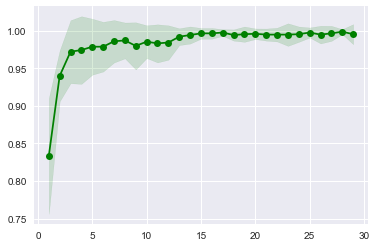

In [214]:
_mean = np.empty(df.shape[1])
_std = np.empty(df.shape[1])
clf = RandomForestClassifier(random_state = randomState)

for i in range(df.shape[1]):
    print(f'shape of x: {x[FI.feature[:i+1]].shape}', end = ' ')
    score = cross_val_score(clf, x[FI.feature[:i+1]], y, cv = 10, scoring = 'roc_auc')
    _mean[i] = score.mean()
    _std[i] = score.std()
    print(f'RF: {score.mean()} \u00B1 {score.std()}')
plt.plot(range(1, df.shape[1] + 1), _mean, color = 'g', marker = 'o')
plt.fill_between(range(1, df.shape[1] + 1), _mean + _std, _mean - _std, alpha = 0.15, color = 'green')
plt.show()

### 七、導入/部署